# UNet using OOPS

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

Defining the double convolution step

In [2]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self,x):
      return self.conv(x)

Defining the downsampling + double convolution step

In [3]:
class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Down, self).__init__()
    self.avgpool_conv = nn.Sequential(
        nn.AvgPool2d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
      return self.avgpool_conv(x)

Defining the upsampling + double convolution step

In [4]:
class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Up, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, 2, 2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, skip):
    x1 = self.up(x1)
    diffY = skip.size()[2] - x1.size()[2]
    diffX = skip.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    x = torch.cat([skip, x1], dim=1)
    return self.conv(x)


Defining the out convolution

In [5]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.conv(x))

Defining the model

In [6]:
class UNet(nn.Module):
  def __init__(self, in_channels = 3, out_channels = 3, features = [64,128,256,512]):
    super(UNet, self).__init__()
    self.inc = DoubleConv(in_channels, features[0])
    self.down1 = Down(features[0], features[1])
    self.down2 = Down(features[1], features[2])
    self.down3 = Down(features[2], features[3])
    self.down4 = Down(features[3], features[3]*2) #bridging step
    self.up1 = Up(features[3]*2, features[3])
    self.up2 = Up(features[3], features[2])
    self.up3 = Up(features[2], features[1])
    self.up4 = Up(features[1], features[0])
    self.outc = OutConv(features[0], out_channels)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    output = self.outc(x)
    return output

# Loading Data

In [7]:
# !pip install -q kaggle

In [8]:
# from google.colab import files
# files.upload()

In [9]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [10]:
# !kaggle datasets download -d kwentar/blur-dataset

In [11]:
# !unzip blur-dataset.zip

In [12]:
sorted(os.listdir('/content/motion_blurred'))
sorted(os.listdir('/content/sharp'))

['0_IPHONE-SE_S.JPG',
 '100_NIKON-D3400-35MM_S.JPG',
 '101_NIKON-D3400-35MM_S.JPG',
 '102_NIKON-D3400-35MM_S.JPG',
 '103_HUAWEI-P20_S.jpg',
 '104_IPHONE-SE_S.jpg',
 '105_IPHONE-SE_S.jpg',
 '106_NIKON-D3400-35MM_S.JPG',
 '107_XIAOMI-MI8-SE_S.jpg',
 '108_XIAOMI-MI8-SE_S.jpg',
 '109_HONOR-7X_S.jpg',
 '10_ASUS-ZENFONE-LIVE-ZB501KL_S.jpg',
 '110_IPHONE-7_S.jpeg',
 '111_IPHONE-7_S.jpeg',
 '112_NIKON-D3400-35MM_S.JPG',
 '113_SAMSUNG-GALAXY-A5_S.jpg',
 '114_ASUS-ZE500KL_S.jpg',
 '115_NIKON-D3400-35MM_S.JPG',
 '116_BQ-5512L_S.jpg',
 '117_HONOR-7X_S.jpg',
 '118_HONOR-7X_S.jpg',
 '119_HONOR-7X_S.jpg',
 '11_XIAOMI-MI8-SE_S.jpg',
 '120_HONOR-7X_S.jpg',
 '121_HONOR-7X_S.jpg',
 '122_HONOR-7X_S.jpg',
 '123_NIKON-D3400-35MM_S.JPG',
 '124_HONOR-7X_S.jpg',
 '125_NIKON-D3400-35MM_S.JPG',
 '126_NIKON-D3400-18-55MM_S.JPG',
 '127_IPHONE-8_S.jpeg',
 '128_XIAOMI-MI8-SE_S.jpg',
 '129_NIKON-D3400-18-55MM_S.JPG',
 '12_SAMSUNG-GALAXY-J5_S.jpg',
 '130_NIKON-D3400-18-55MM_S.JPG',
 '131_NIKON-D3400-18-55MM_S.JPG',
 '

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
class UNetDataset(Dataset):
    def __init__(self, bdir, sdir):
        self.bdir = bdir
        self.sdir = sdir
        self.bimages = sorted(list(self.bdir + '/' + file_name for file_name in sorted(os.listdir(self.bdir))))
        self.simages = sorted(list(self.sdir + '/' + file_name for file_name in sorted(os.listdir(self.sdir))))
        self.transform = transforms.Compose([
            transforms.Resize((286, 286)),
            transforms.ToTensor()])

    def __len__(self):
        return len(self.bimages)

    def __getitem__(self, index):
        b_img = Image.open(self.bimages[index])
        b_img = self.transform(b_img)
        s_img = Image.open(self.simages[index])
        s_img = self.transform(s_img)
        return (b_img.to(device), s_img.to(device))

In [15]:
img = cv2.imread('/content/sharp/0_IPHONE-SE_S.JPG')
# img = transforms.ToTensor()(img)
# print(img.transpose(2,0,1).shape)
# img = Image.open('/content/sharp/0_IPHONE-SE_S.JPG')
print(img.shape)

(2048, 1536, 3)


In [34]:
def show_batch(image_batch, title):
    plt.figure(figsize=(17,17))
    grid = torchvision.utils.make_grid(image_batch, nrow=10)
    # print(grid.shape)
    plt.imshow(grid.cpu().detach().numpy().transpose(1,2,0))
    plt.title(title)
    plt.show()

In [17]:
dataset = UNetDataset(bdir='/content/motion_blurred', sdir='/content/sharp')
# sharp_dataset = UNetDataset(dir='/content/sharp')

In [18]:
model = UNet()

# Training

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
BATCH_SIZE = 10
EPOCHS = 20
LR = 1e-2

In [21]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset)

0
torch.Size([10, 3, 286, 286])
torch.Size([10, 3, 286, 286])


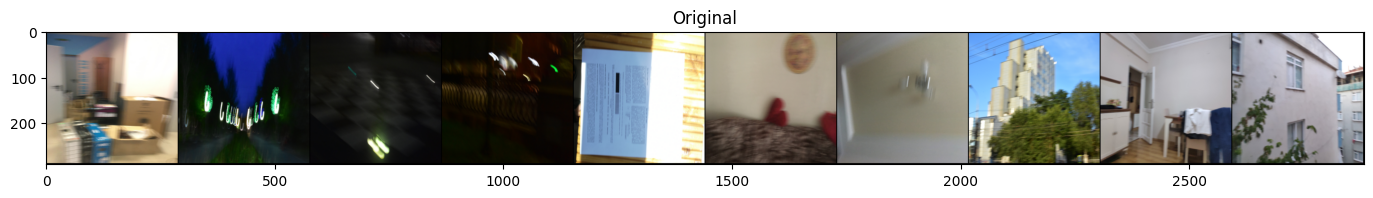

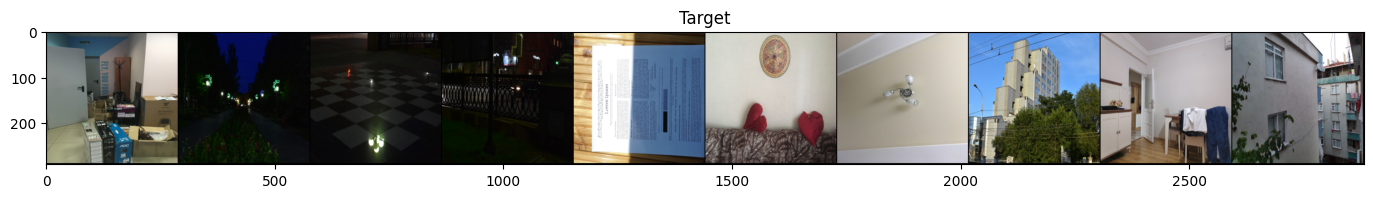

In [22]:
for i_batch, batch in enumerate(train_dataset):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = UNet().to(device)
  print(i_batch)
  print(batch[0].shape)
  print(batch[1].shape)
  # print(model(batch[0]).shape)
  show_batch(batch[0], "Original")
  # show_batch(model(batch[0]), "Output")
  show_batch(batch[1], "Target")
  break

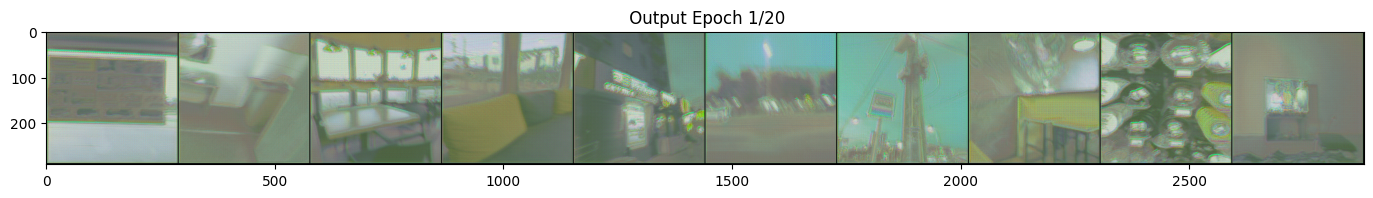

Epoch 1 :  2.260669942945242


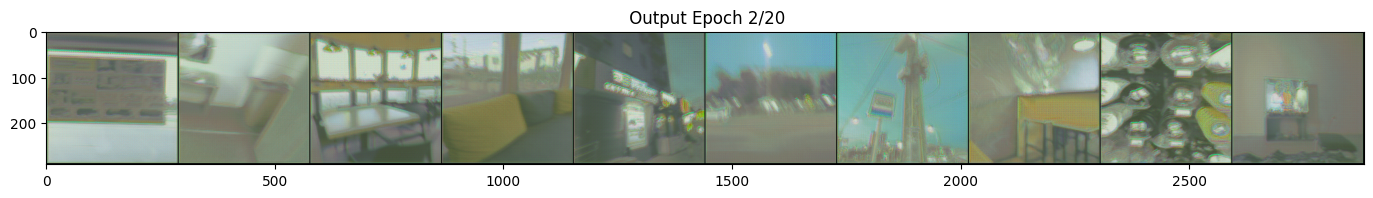

Epoch 2 :  1.9474483244121075


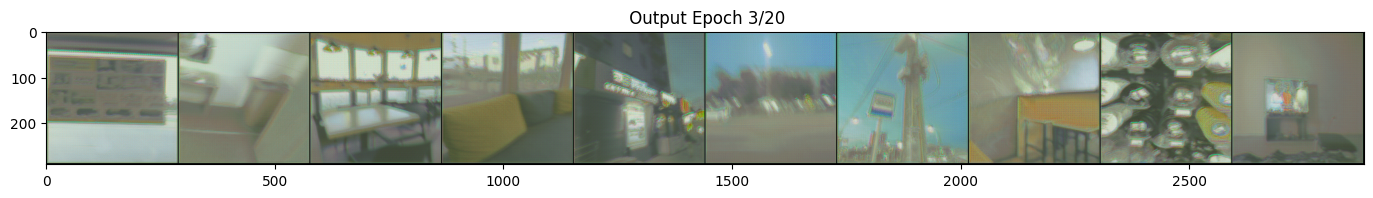

Epoch 3 :  1.828644085675478


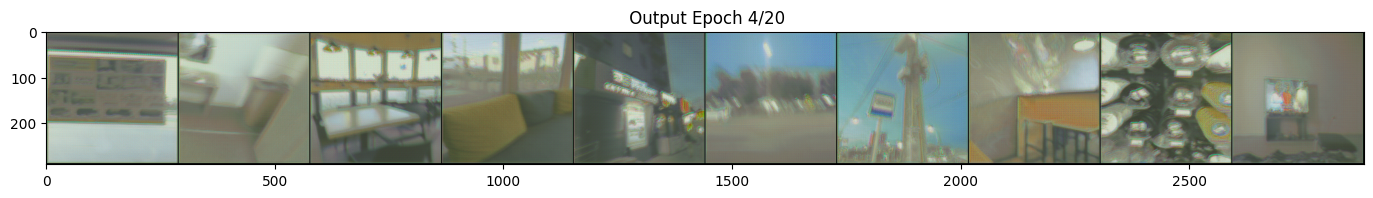

Epoch 4 :  1.75810182467103


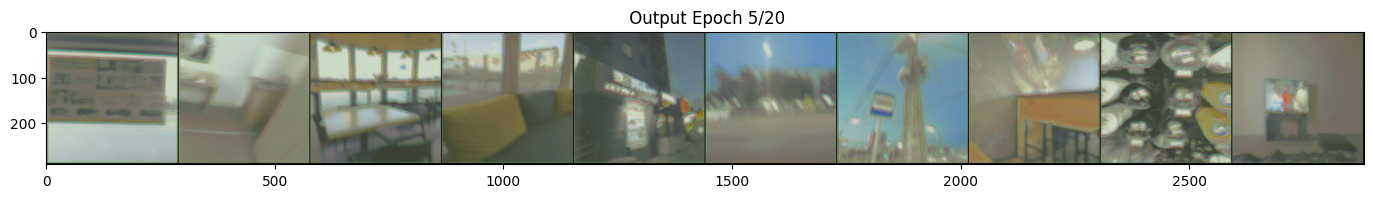

Epoch 5 :  1.7098824568092823


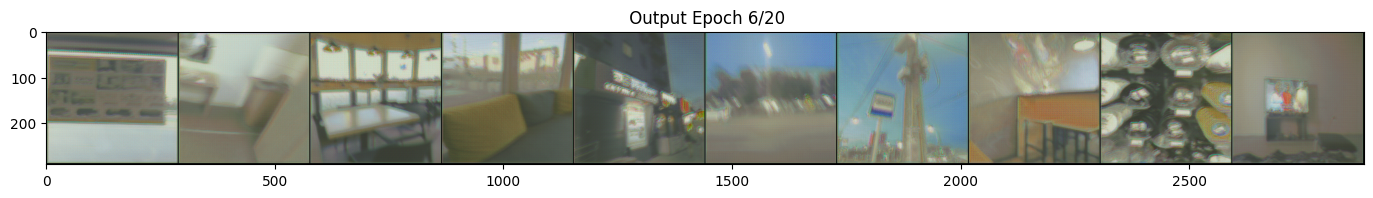

Epoch 6 :  1.6747272852808237


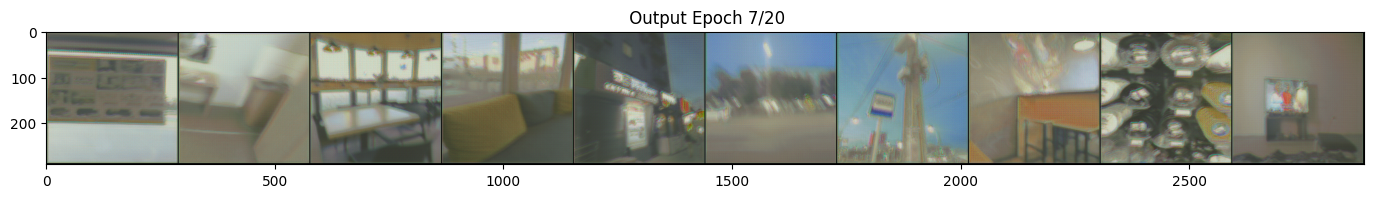

Epoch 7 :  1.6481192521750927


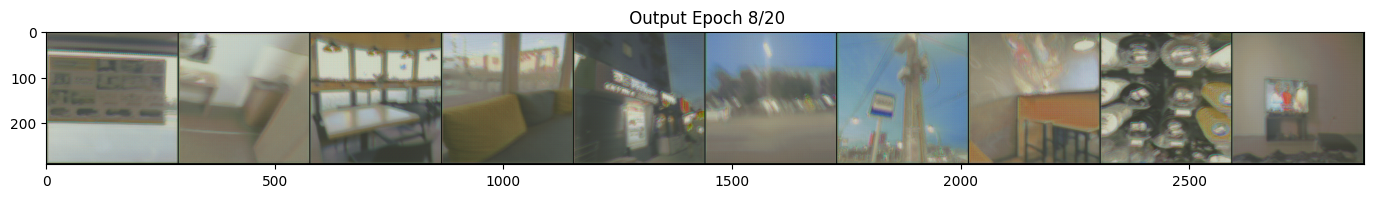

Epoch 8 :  1.6275239810347557


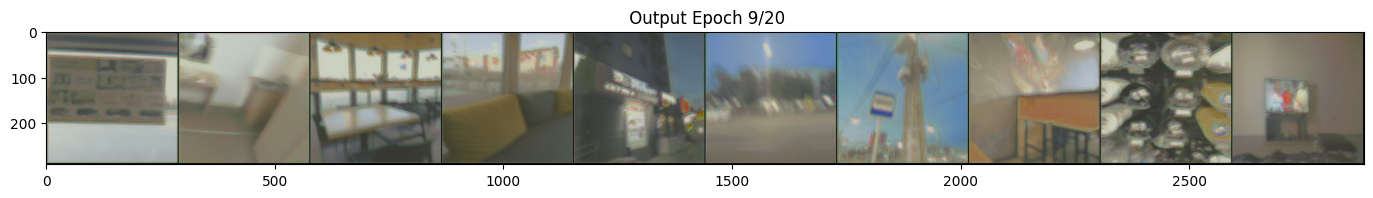

Epoch 9 :  1.611374706029892


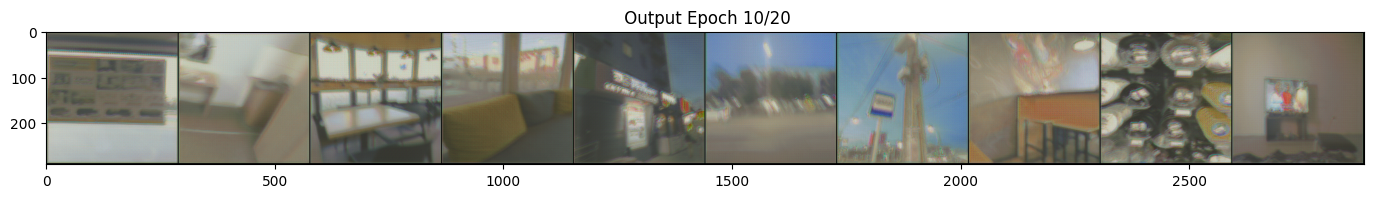

Epoch 10 :  1.5985487774014473


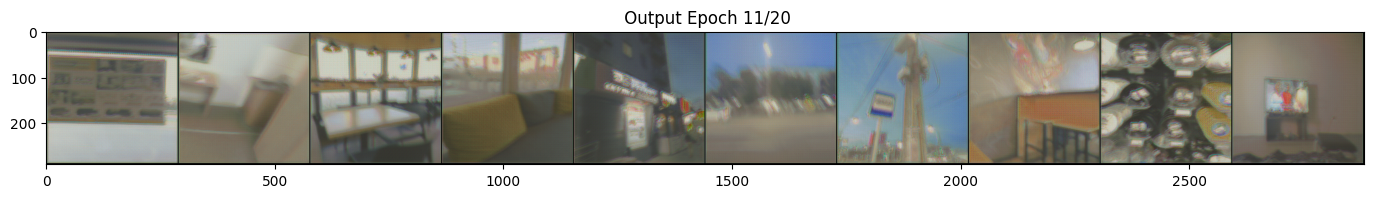

Epoch 11 :  1.588232422247529


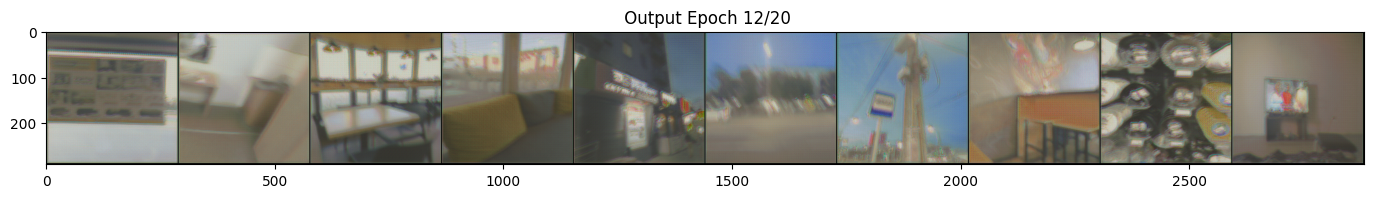

Epoch 12 :  1.5798340179026127


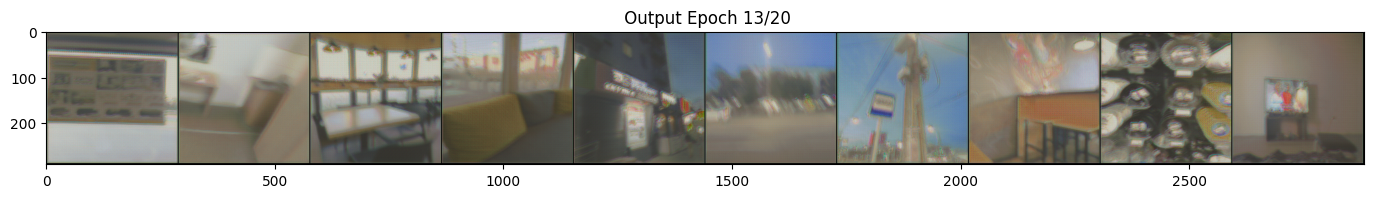

Epoch 13 :  1.5729115102440119


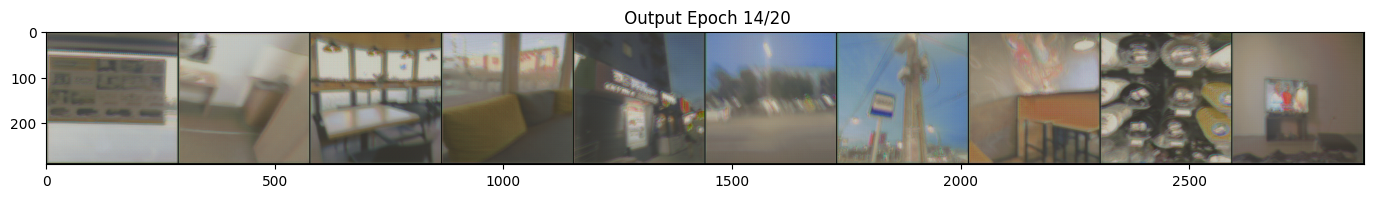

Epoch 14 :  1.5671347808092833


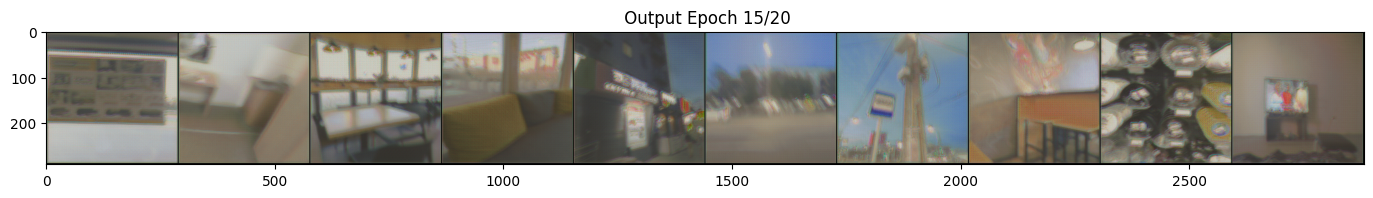

Epoch 15 :  1.5622558631002903


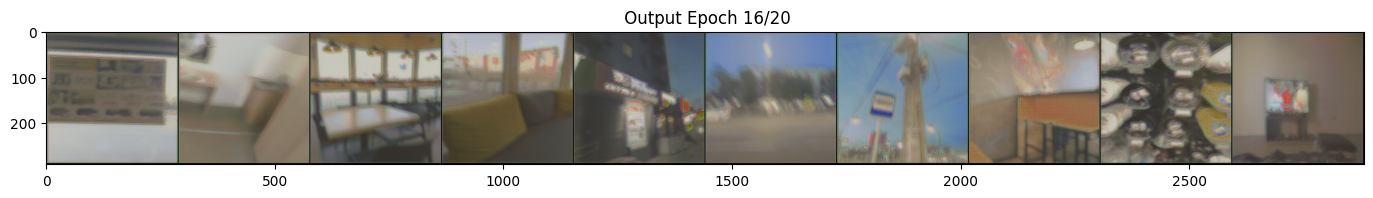

Epoch 16 :  1.5580848474055529


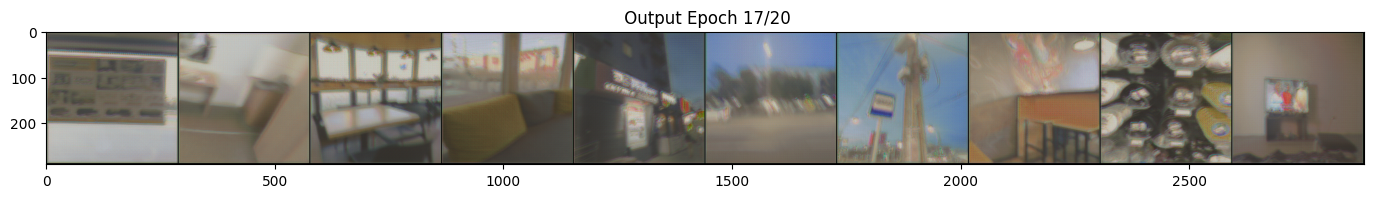

Epoch 17 :  1.5544746555387974


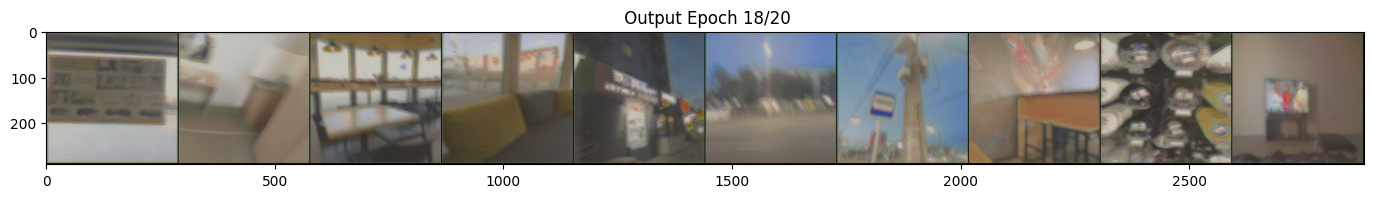

Epoch 18 :  1.5513043217360973


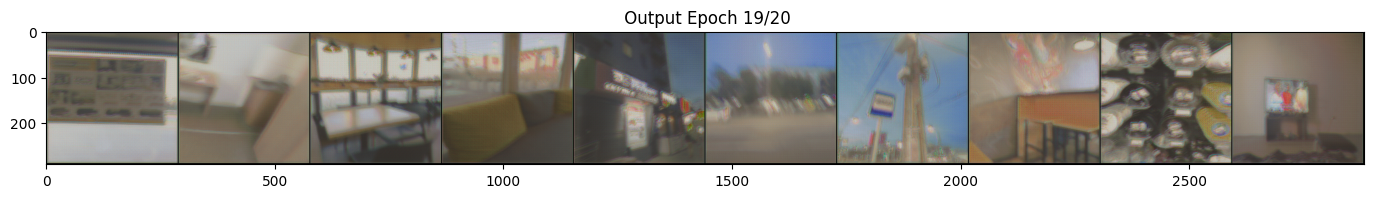

Epoch 19 :  1.5484927669167519


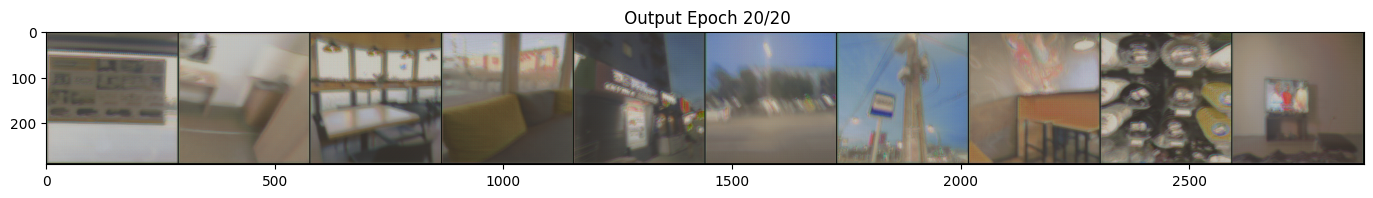

Epoch 20 :  1.5459686946123838


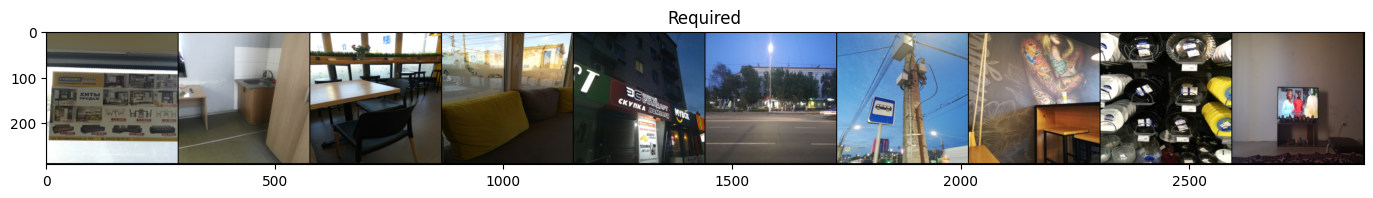

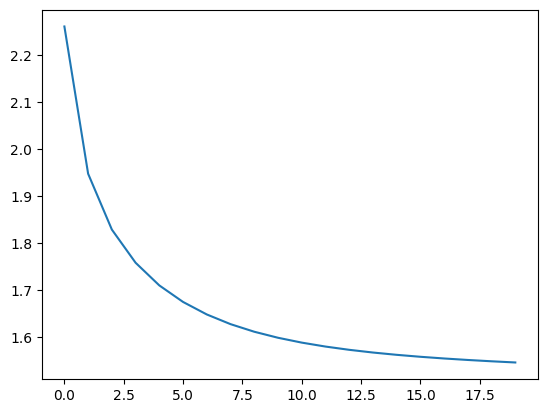

In [23]:
model = UNet().to(device)
criterion = nn.MSELoss() # sqaure of MSELoss
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
losses = []
for epoch in range(0, EPOCHS):
  running_loss = 0
  for i_batch, batch in enumerate(train_dataset):
    model.train(True)
    optimizer.zero_grad()
    output = model(batch[0])
    loss = criterion(batch[1], output)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    # if i_batch % 10 == 0:
    # show_batch(batch[0], f"Starting With Epoch {epoch+1}, Batch {i_batch+1})")
    # show_batch(output, f" Output Epoch {epoch+1}/{EPOCHS}, Batch {i_batch+1}/{len(train_dataset)//BATCH_SIZE}")
    # show_batch(batch[1], f"Required Epoch {epoch+1}, Batch {i_batch+1})")
  show_batch(output, f" Output Epoch {epoch+1}/{EPOCHS}")
  losses.append(running_loss)
  print(f"Epoch {epoch+1} : ", running_loss)
  if epoch == EPOCHS - 1:
    show_batch(batch[1], f"Required")
plt.plot(losses)
plt.show()

In [42]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=10)

In [44]:
for i_batch, batch in enumerate(test_dataloader):
  show_batch(batch[0],'Original')
  show_batch(model(batch[0]), 'Prediction')
  show_batch(batch[1],'Target')
  break

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 